# 12wk-2: (순환신경망) – RNNCell, RNN, LSTM, Appedix A

최규빈  
2025-05-26

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/12wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-x1SCKjv1F3h5PcBc_jKncC&si=Yph4Mk79epP_ptM1>

# 2. Imports

In [49]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 3. Data – `AbAcAd`

`-` 데이터정리

In [50]:
txt = list('AbAcAd'*50)
txt[:10]

In [51]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

In [52]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [53]:
X.shape, y.shape

# 4. `rNNCell` – 복습

In [73]:
# 간장을 만드는 방법 
# 콩물1, 간장0 ---숙성---> 간장1 
# 콩물2, 간장1 ---숙성---> 간장2
# 
# RNNCell
# Xt, h_{t-1} 
# ---concat--->  [Xt  h_{t-1}] 
# ---선변------> linr ( [Xt  h_{t-1}] ) 
# ---tanh----> tanh  (linr ( [Xt  h_{t-1}] ) ) = ht
# Xt, h_{t-1} 
# ---선변--->  linr1(Xt) + linr2(ht) 
# ---tanh----> tanh  ( linr1(Xt) + linr2(ht) ) = ht
# 
# ht ---> ot = logits = cook(ht) ---> yt_hat = soft_max(ot) 

In [193]:
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2)
        self.h2h = torch.nn.Linear(2,2)
        self.tanh = torch.nn.Tanh()
    def forward(self,Xt,ht): # 엄밀하게는 h_{t-1}
        ht = self.tanh(self.i2h(Xt) + self.h2h(ht)) 
        return ht
torch.manual_seed(43052)
rnncell = rNNCell()
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(
    list(rnncell.parameters()) + 
    list(cook.parameters()),
    lr=0.1
)
#---#
L = len(X)
for epoc in range(200):
    # 1~2 
    loss = 0
    ht = torch.zeros(2) # 첫 ht는 맹물
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt,ht)
        ot = cook(ht)
        loss = loss_fn(ot,yt) + loss 
    loss = loss / L 
    # 3
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [194]:
h = torch.zeros(L,2) 
water = torch.zeros(2)
h[0] = rnncell(X[0], water)
for t in range(1,L):
    h[t] = rnncell(X[t], h[t-1])
out = cook(h)
yhat = torch.nn.functional.softmax(out,dim=1) 
yhat

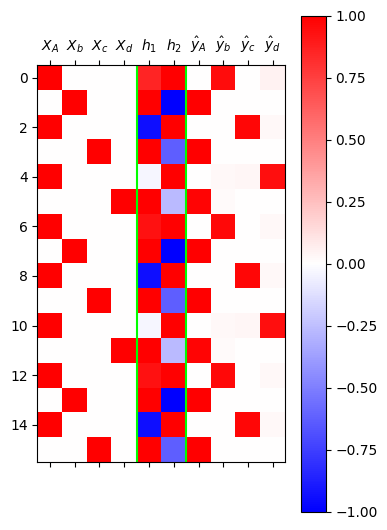

In [195]:
mat = torch.concat( [X, h, yhat] , axis=1).data 
plt.matshow(mat[:16],cmap="bwr",vmin=-1,vmax=1)
plt.colorbar()
plt.xticks(
    range(10),
    [r"$X_A$",r"$X_b$",r"$X_c$",r"$X_d$",
     r"$h_1$",r"$h_2$",
     r"$\hat{y}_A$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"]
);
plt.axvline(x=3.5,color='lime')
plt.axvline(x=5.5,color='lime')

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

`-` `torch.nn.RNNCell`을 이용하여 학습

In [181]:
torch.manual_seed(0)
rnncell = torch.nn.RNNCell(
    input_size = 4, #X.shape = (L,4)
    hidden_size= 2, # h.shape = (L,2) 
)
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(
    list(rnncell.parameters()) + 
    list(cook.parameters()),
    lr=0.1
)
#---#
L = len(X)
for epoc in range(200):
    # 1~2 
    loss = 0
    ht = torch.zeros(2) # 첫 ht는 맹물
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt,ht)
        ot = cook(ht)
        loss = loss_fn(ot,yt) + loss 
    loss = loss / L 
    # 3
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [182]:
h = torch.zeros(L,2) 
water = torch.zeros(2)
h[0] = rnncell(X[0], water)
for t in range(1,L):
    h[t] = rnncell(X[t], h[t-1])
out = cook(h)
yhat = torch.nn.functional.softmax(out,dim=1) 
yhat

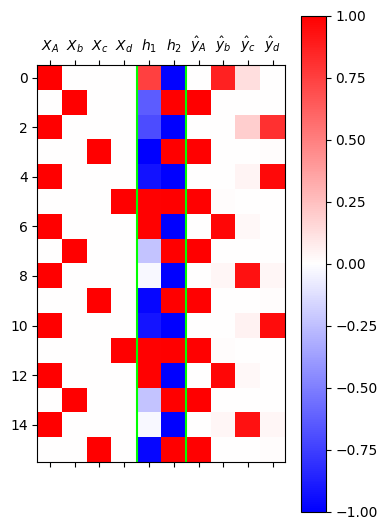

In [183]:
mat = torch.concat( [X, h, yhat] , axis=1).data 
plt.matshow(mat[:16],cmap="bwr",vmin=-1,vmax=1)
plt.colorbar()
plt.xticks(
    range(10),
    [r"$X_A$",r"$X_b$",r"$X_c$",r"$X_d$",
     r"$h_1$",r"$h_2$",
     r"$\hat{y}_A$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"]
);
plt.axvline(x=3.5,color='lime')
plt.axvline(x=5.5,color='lime')

`-` `torch.nn.RNNCell`의 가중치를 이전에 직접 설계한 `rNNCell`와
동일하게 설정한 이후 학습

-   왜 이런것을 하지? 우리가 직접만들어본 클래스 `rNNCell`이 torch에서
    기본제공하는 `torch.nn.RNNCell`와 동일기능을 수행한다는 것을
    확인하기 위함

In [191]:
torch.manual_seed(43052)
_rnncell = rNNCell()
cook = torch.nn.Linear(2,4)
rnncell = torch.nn.RNNCell(4,2)
rnncell.weight_ih.data = _rnncell.i2h.weight.data
rnncell.weight_hh.data =  _rnncell.h2h.weight.data
rnncell.bias_ih.data = _rnncell.i2h.bias.data
rnncell.bias_hh.data = _rnncell.h2h.bias.data
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(
    list(rnncell.parameters()) + 
    list(cook.parameters()),
    lr=0.1
)
#---#
L = len(X)
for epoc in range(200):
    # 1~2 
    loss = 0
    ht = torch.zeros(2) # 첫 ht는 맹물
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt,ht)
        ot = cook(ht)
        loss = loss_fn(ot,yt) + loss 
    loss = loss / L 
    # 3
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [192]:
h = torch.zeros(L,2) 
water = torch.zeros(2)
h[0] = rnncell(X[0], water)
for t in range(1,L):
    h[t] = rnncell(X[t], h[t-1])
out = cook(h)
yhat = torch.nn.functional.softmax(out,dim=1) 
yhat

# 6. `torch.nn.RNN`

ref: <https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html>

`-` `torch.nn.RNNCell` 에서의 차원정리

|  | `torch.nn.RNNCell`, 배치사용 X | `torch.nn.RNNCell`, 배치사용 O |
|:------:|:------------------------------:|:------------------------------:|
| ${\bf X}$ | $(L,H_{in})$ | $(L, N, H_{in})$ |
| ${\boldsymbol h}$ | $(L,H_{out})$ | $(L, N, H_{out})$ |
| ${\bf y}$ | $(L,Q)$ | $(L, N, Q)$ |
| $X_t$ | $(H_{in},)$ | $(N, H_{in})$ |
| $h_t$[1] | $(H_{out},)$ | $(N, H_{out})$ |
| $y_t$ | $(Q,)$ | $(N,Q)$ |

`-` `torch.nn.RNN` 에서의 차원정리

|  | `torch.nn.RNN`, 배치사용 X | `torch.nn.RNN`, 배치사용 O |
|:------:|:------------------------------:|:------------------------------:|
| ${\bf X}$ | $(L,H_{in})$ | $(L, N, H_{in})$ |
| ${\boldsymbol h}$ | $(L,H_{out})$ | $(L, N, H_{out})$ |
| ${\bf y}$ | $(L,Q)$ | $(L, N, Q)$ |
| ${\boldsymbol h}_x$[2] | $(D\times {\tt num\_layers},H_{out})$ | $(D\times {\tt num\_layers},N,H_{out})$ |

`-` `torch.nn.RNN`을 활용한 학습

[1] =`water`

[2] =`waters`

In [159]:
torch.manual_seed(0)
rnn = torch.nn.RNN(
    input_size  = 4, # X.shape = (L,4)
    hidden_size = 2, # h.shape = (L,2)
    num_layers = 1,  # num_layers = 1 이라는 의미 
    bidirectional = False # D=1 이라는 의미 
)    
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(
    list(rnn.parameters())+
    list(cook.parameters()),
    lr=0.1
)
#---#
for epoc in range(200):
    # 1
    waters = torch.zeros(1,2) # 1은 D*num_layers 를 의미 
    h, hL = rnn(X,waters) # rnn의 결과는 길이가 2인 튜플이고, 첫원소가 h 
    netout = cook(h)
    # 2 
    loss = loss_fn(netout, y)
    # 3
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [160]:
yhat = torch.nn.functional.softmax(netout,dim=1)

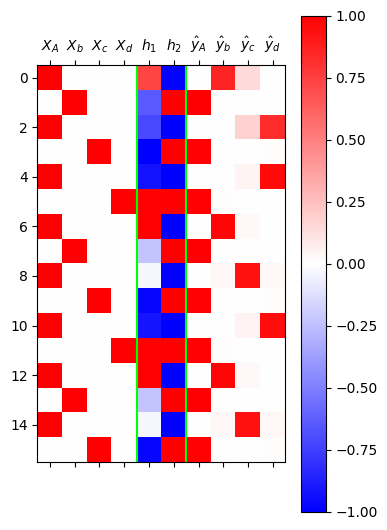

In [161]:
mat = torch.concat( [X, h, yhat] , axis=1).data 
plt.matshow(mat[:16],cmap="bwr",vmin=-1,vmax=1)
plt.colorbar()
plt.xticks(
    range(10),
    [r"$X_A$",r"$X_b$",r"$X_c$",r"$X_d$",
     r"$h_1$",r"$h_2$",
     r"$\hat{y}_A$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"]
);
plt.axvline(x=3.5,color='lime')
plt.axvline(x=5.5,color='lime')

`-` `torch.nn.RNN`의 가중치를 이전에 직접 설계한 `rNNCell`와 동일하게
설정한 이후 학습

In [189]:
torch.manual_seed(43052)
_rnncell = rNNCell()
cook = cook = torch.nn.Linear(2,4)
rnn = torch.nn.RNN(
    input_size  = 4, # X.shape = (L,4)
    hidden_size = 2, # h.shape = (L,2)
    num_layers = 1,  # num_layers = 1 이라는 의미 
    bidirectional = False # D=1 이라는 의미 
)    
rnn.weight_hh_l0.data = _rnncell.h2h.weight.data
rnn.weight_ih_l0.data = _rnncell.i2h.weight.data
rnn.bias_hh_l0.data = _rnncell.h2h.bias.data
rnn.bias_ih_l0.data = _rnncell.i2h.bias.data
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(
    list(rnn.parameters())+
    list(cook.parameters()),
    lr=0.1
)
#---#
for epoc in range(200):
    # 1
    waters = torch.zeros(1,2) # 1은 D*num_layers 를 의미 
    h, hL = rnn(X,waters) # rnn의 결과는 길이가 2인 튜플이고, 첫원소가 h 
    netout = cook(h)
    # 2 
    loss = loss_fn(netout, y)
    # 3
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [190]:
h,_ = rnn(X,waters)
netout = cook(h)
yhat = torch.nn.functional.softmax(netout,dim=1)
yhat

In [206]:
#위의 결과는 아래와 다르지만 그냥 같다고 생각합시다. 
# tensor([[4.1978e-03, 9.4555e-01, 1.9557e-06, 5.0253e-02],
#         [9.9994e-01, 5.5569e-05, 8.4751e-10, 1.3143e-06],
#         [2.1349e-07, 1.1345e-06, 9.7019e-01, 2.9806e-02],
#         ...,
#         [2.1339e-07, 1.1339e-06, 9.7020e-01, 2.9798e-02],
#         [9.9901e-01, 9.6573e-04, 6.9303e-09, 2.1945e-05],
#         [7.2919e-04, 2.5484e-02, 3.3011e-02, 9.4078e-01]],
#        grad_fn=<SoftmaxBackward0>)

> **Note**
>
> **재현값이 차이나는 이유**
>
> 재현값의 차이는 단순한 수치 오차(numerical error)로 보입니다. 문제
> 상황에서 에포크를 약 50회 수행했을 때는 재현값 사이에 차이가 없었지만,
> 100회 이상 수행하면서 약간의 차이가 발생하기 시작했습니다. 이는
> 컴퓨터가 소수점 아래 여러 자릿수를 생략하고 근사값으로 계산하기
> 때문에, 동일한 연산이라도 반복적으로 적용되면 누적된 오차로 인해
> 결과가 달라질 수 있기 때문으로 보입니다.
>
> 예를 들어, 아래의 코드에서 이러한 차이를 확인할 수 있습니다:
>
> ``` python
> torch.tensor([1/3]*100000).sum(), torch.tensor([1/3])*100000
> ```
>
> 출력 결과는 다음과 같습니다:
>
>     (tensor(33333.3398), tensor([33333.3359]))
>
> 이론적으로는 두 연산이 동일한 값을 반환해야 하지만, 내부적인 계산
> 방식의 차이로 인해 소수점 셋째 자리에서 미세한 오차가 발생합니다.
> (물론 전체적인 값에는 큰 차이가 없습니다.) 수업 시간에 발생한 상황도
> 이와 유사한 수치 오차로 인한 현상으로 보입니다.

# 7. `torch.nn.LSTM`

`-` `torch.nn.LSTM`을 이용하여 학습

In [158]:
torch.manual_seed(5)
lstm = torch.nn.LSTM(
    input_size  = 4, # X.shape = (L,4)
    hidden_size = 2, # h.shape = (L,2)
    num_layers = 1,  # num_layers = 1 이라는 의미 
    bidirectional = False # D=1 이라는 의미 
)    
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(
    list(lstm.parameters())+
    list(cook.parameters()),
    lr=0.1
)
#---#
for epoc in range(200):
    # 1
    h, _ = lstm(X) # rnn의 결과는 길이가 2인 튜플이고, 첫원소가 h 
    netout = cook(h)
    # 2 
    loss = loss_fn(netout, y)
    # 3
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [159]:
yhat = torch.nn.functional.softmax(netout,dim=1)

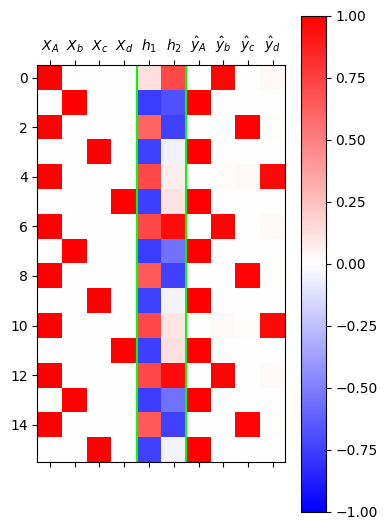

In [160]:
mat = torch.concat( [X, h, yhat] , axis=1).data 
plt.matshow(mat[:16],cmap="bwr",vmin=-1,vmax=1)
plt.colorbar()
plt.xticks(
    range(10),
    [r"$X_A$",r"$X_b$",r"$X_c$",r"$X_d$",
     r"$h_1$",r"$h_2$",
     r"$\hat{y}_A$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"]
);
plt.axvline(x=3.5,color='lime')
plt.axvline(x=5.5,color='lime')

> **Note**
>
> **LSTM** 관련 공부자료
>
> -   <https://guebin.github.io/DL2024/posts/13wk-1.html>
> -   <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>
> -   <https://docs.pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html>

# Appendix A – 용어 정리 ($\star$)

## A. ${\bf X}$, ${\bf y}$

`-` X, y를 지칭하는 이름

| 기호 | 용어 | 설명 |
|:------:|:------------------------------:|:-------------------------------|
| ${\bf X}$ | 설명변수 <br/> (Explanatory Variable) | 종속변수(반응변수)를 설명하거나 예측하는 데 사용되는 변수로, 전통 통계 및 머신러닝에서의 입력 역할 |
|  | 독립변수 <br/> (Independent Variable) | 전통적인 통계학 및 회귀 분석 문맥에서 사용됨 |
|  | 입력변수 <br/> (Input Variable) | 머신러닝 모델에서 입력 데이터로 사용되며, 특히 신경망 구조 등에서 많이 쓰임 |
|  | 특징 / 특성 <br/> (Feature) | 머신러닝, 데이터마이닝, 딥러닝 등에서 데이터를 구성하는 속성 또는 설명 변수로 사용됨 |
|  | 예측 변수 <br/> (Predictor) | 예측 모델 설계 시 독립변수를 지칭하는 용어로, 모델링/통계 분석 문맥에서 흔히 사용됨 |
|  | 공변량 <br/> (Covariate) | 실험 디자인, 특히 임상연구나 사회과학 연구에서 제어 변수로 사용됨 |
|  |  |  |
| ${\bf y}$ | 반응변수 <br/> (Response Variable) | 독립변수의 영향을 받는 결과 변수로, 모델링이나 인과 추론에서 핵심적인 대상 |
|  | 종속변수 <br/> (Dependent Variable) | 전통 통계학과 회귀분석에서 사용되며, 독립변수의 영향을 받는 변수로 정의됨 |
|  | 출력변수 <br/> (Output Variable) | 머신러닝 및 딥러닝에서 모델의 예측 결과로 출력되는 값으로 사용됨 |
|  | 타겟 / 정답 <br/> (Target / Label) | 지도학습에서 모델이 학습해야 하는 실제 정답값을 의미하며, 분류/회귀 문제에 공통적으로 사용됨 |

`-` 더 다양함: <https://ko.wikipedia.org/wiki/독립변수와_종속변수>

## B. 지도학습

`-` 우리가 수업에서 다루는 데이터는 주로 아래와 같은 느낌이다.

1.  데이터는 $(X,y)$ 의 형태로 정리되어 있다.

2.  $y$는 우리가 관심이 있는 변수이다. 즉 우리는 $y$를 적절하게 추정하는
    것에 관심이 있다.

3.  $X$는 $y$를 추정하기 위해 필요한 정보이다.

| $X$ | $y$ | 비고 | 순서 | 예시 |
|:------------:|:--------------:|:----------:|:----------:|:------------------:|
| 기온(온도) | 아이스 아메리카노 판매량 | 회귀 | 상관없음 | 날씨가 판매량에 미치는 영향 분석 |
| 스펙 | 합격 여부 | 로지스틱 | 상관없음 | 입사 지원자의 합격 예측 |
| 이미지 | 카테고리 | 합성곱신경망 (CNN) | 상관없음 | 개/고양이 이미지 구분 |
| 유저, 아이템 정보 | 평점 | 추천시스템 | 상관없음 | 넷플릭스 영화 추천 |
| 처음 $m$개의 단어(문장) | 이후 1개의 단어(문장) | 순환신경망 (RNN) | 순서 상관 있음 | 챗봇, 문장 생성, 언어 모델링 |
| 처음 $m$개의 단어(문장) | 카테고리 | 순환신경망 (RNN) | 순서 상관 있음 | 영화리뷰 감정 분류 |

`-` 이러한 문제상황, 즉 $(X,y)$가 주어졌을때 $X \to y$를 추정하는 문제를
supervised learning 이라한다.

## C. 모델이란?

`-` 통계학에서 모델은 y와 x의 관계를 의미하며 오차항의 설계를 포함하는
개념이다. 이는 통계학이 “데이터 = 정보 + 오차”의 관점을 유지하기
때문이다. 따라서 통계학에서 모델링이란

$$y_i = net(x_i) + \epsilon_i$$

에서 (1) 적절한 함수 $net$를 선택하는 일 (2) 적절한 오차항 $\epsilon_i$
을 설계하는일 모두를 포함한다.

`-` 딥러닝 혹은 머신러닝에서 모델은 단순히

$$y_i \approx net(x_i)$$

를 의미하는 경우가 많다. 즉 “model=net”라고 생각해도 무방하다. 이 경우
“모델링”이란 단순히 적절한 $net$을 설계하는 것만을 의미할 경우가 많다.

`-` 그래서 생긴일

-   통계학교재 특징: 분류문제와 회귀문제를 엄밀하게 구분하지 않는다.
    사실 오차항만 다를뿐이지 크게보면 같은 회귀모형이라는 관점이다.
    그래서 일반화선형모형(GLM)이라는 용어를 쓴다.
-   머신러닝/딥러닝교재 특징: 회귀문제와 분류문제를 구분해서 설명한다.
    (표도 만듦) 이는 오차항에 대한 기술을 모호하게 하여 생기는 현상이다.

## D. 학습이란?

`-` 학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
“규칙” 혹은 “원리”를 찾는 것이다.

-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “맵핑”을 찾는 것이다.
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “함수”을 찾는 것이다. 즉 $y\approx f(X)$가 되도록 만드는 $f$를 잘
    찾는 것이다. (이 경우 “함수를 추정한다”라고 표현)
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “모델” 혹은 “모형”을 찾는 것이다. 즉 $y\approx model(X)$가 되도록
    만드는 $model$을 잘 찾는 것이다. (이 경우 “모형을 학습시킨다”라고
    표현)
-   **학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는
    어떠한 “네트워크”을 찾는 것이다. 즉 $y\approx net(X)$가 되도록
    만드는 $net$을 잘 찾는 것이다. (이 경우 “네트워크를 학습시킨다”라고
    표현)**

`-` prediction이란 학습과정에서 찾은 “규칙” 혹은 “원리”를 $X$에 적용하여
$\hat{y}$을 구하는 과정이다. 학습과정에서 찾은 규칙 혹은 원리는
$f$,$model$,$net$ 으로 생각가능한데 이에 따르면 아래가 성립한다.

-   $\hat{y} = f(X)$
-   $\hat{y} = model(X)$
-   $\hat{y} = net(X)$

## E. $\hat{y}$를 부르는 다양한 이름

`-` $\hat{y}$는 $X$가 주어진 자료에 있는 값인지 아니면 새로운 값 인지에
따라 지칭하는 이름이 미묘하게 다르다.

1.  $X \in data$: $\hat{y}=net(X)$ 는 predicted value, fitted value 라고
    부른다.

2.  $X \notin data$: $\hat{y}=net(X)$ 는 predicted value, predicted
    value with new data 라고 부른다.

## F. 다양한 코드들

`-` 파이썬 코드..

``` python
#Python
predictor.fit(X,y) # autogluon 에서 "학습"을 의미하는 과정
model.fit(X,y) # sklearn 에서 "학습"을 의미하는 과정
trainer.train() # huggingface 에서 "학습"을 의미하는 과정
trainer.predict(dataset) # huggingface 에서 "예측"을 의미하는 과정
model.fit(x, y, batch_size=32, epochs=10) # keras에서 "학습"을 의미하는 과정
model.predict(test_img) # keras에서 "예측"을 의미하는 과정 
```

`-` R 코드..

``` r
# R
ols <- lm(y~x) # 선형회귀분석에서 학습을 의미하는 함수
ols$fitted.values # 선형회귀분석에서 yhat을 출력 
predict(ols, newdata=test) # 선형회귀분석에서 test에 대한 예측값을 출력하는 함수
ols$coef # 선형회귀분석에서 weight를 확인하는 방법
```